In [ ]:
import numpy as np
import pickle
import joblib
import torch
import matplotlib.pyplot as plt
from Reg_classif_saxs_deriv2_new_format_mask import SAXSFeatureExtractor, SAXSMultiTask  # Import the model class definition

### Experimental data example
#path = 'Ag_ico_7shells.txt' # ico of more than 3 nm ... 3.5 nm ou 4 nm
# path = 'Au_sphere_7nm.txt'
# path = "Auform_toluene_Img003-005_I(q).dat"
path = "Ag_OY_10_radial_profile.dat" # icosahedron of 3 nm
# path = "APH136-B-Pentane_Img062-067_I(q).dat" # sphere of 3 nm fcc
# Load experimental data
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]

# the data has noise when q > 0.6 so let's try keeping only q < 0.6
q_exp = q_exp[q_exp < 0.6]      
I_exp = I_exp[:len(q_exp)]  # keep only the same number of points in I_exp
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))


# Extrapolate the data to match the q range of the simulated data (padding with zeros)
# use params to find the number of points of the q(saxs) array

# How params was defined earlier in the code:
# params = {
#         'saxs_length': 1600,
#         'n_features': 256,
#         'q_saxs_min': 0.001,
#         'q_saxs_max': 1.6,
#         'output_dim': 1,
#         'n_classes': len(scaler_shape.classes_)
#     }

# Rescale q_exp to match the range of q_saxs : padding with zeros

params = torch.load('cnn_model_params.pth')
saxs_length = params['saxs_length']-1  # 1599
# q_saxs_min= params['q_saxs_min']
# q_saxs_max= params['q_saxs_max']
q_saxs_min = 0.001
q_saxs_max = 1.6
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)
print("Shape of I_exp_interp (should be 1599): ", I_exp_interp.shape) # (1599,)
print("Shape of q_saxs (should be 1599): ", q_saxs.shape) # (1599,)
# print the I_exp_interp values different than 0
print('I_exp_interp', I_exp_interp[I_exp_interp > 0])


# Create Mask (will be defined as the third canal later) = list of 0s and 1s

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1
print('mask and mask shape (should be 1599,): ', mask, mask.shape)
print('any Any 1 in the mask ? :', np.any(mask==1))
print('')


# Transform Iq data : separate q data, logarithm, standardization, standardized derivative

print('... Starting to transform Iq data ...')
# Reshape I_exp_interp and q to have (n_files = 1, 1599)
q_saxs_unique = q_saxs # (1599)
I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)
q_saxs = q_saxs.reshape(1, saxs_length)          # (1, 1599)

print("Shape de q_saxs (should be nfiles, 20000): ", q_saxs.shape)
print("Shape de I_exp_interp (should be nfiles, 1599): ",I_exp_interp.shape) # (nfiles, 1599)
print(" Any I>0 in I_exp_interp ? "   , np.any(I_exp_interp>0))
print("")

# Standardize the derivative
def standardize_derivative(X_deriv):
    mean = np.mean(X_deriv, axis=0, keepdims=True)
    std = np.std(X_deriv, axis=0, keepdims=True)
    return (X_deriv - mean) / std

# Compute standardized derivative (only where the mask = 1)
X_saxs_deriv = np.zeros_like(I_exp_interp)
X_saxs_deriv_std = np.zeros_like(I_exp_interp)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    print('idx where the mask = 1, should be a list of integers:', idx)
    print('is there 1 in the mask ?:', np.any(mask==1))
    if len(idx) > 1:
        # log only on the window where the mask = 1
        I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
        # normalize bu the max value only on the window where the mask = 1
        # I_exp_interp[i, idx] = (I_exp_interp[i, idx]/np.max(I_exp_interp[i, idx]))  # normalize by max in the window where the mask = 1
        # standardize only on the window where the mask = 1
        mean = np.mean(I_exp_interp[i, idx])
        std = np.std(I_exp_interp[i, idx])
        if std > 0:
            I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
        else:
            I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center
        print('Any NaN in I_exp_interp after log and standardization ? :', np.isnan(I_exp_interp).any())
        print('I_exp_interp after log and standardization (only in the window where the mask = 1):', I_exp_interp[i, idx])
        print('')
        print('Calculating derivative and standardized derivative ...')
        print('')
        
        # Calcul de la dérivée uniquement sur la fenêtre informative
        deriv = np.gradient(I_exp_interp[i, idx], q_saxs_unique[idx])
        X_saxs_deriv[i, idx] = deriv
        # apply standardization of the derivative only on the window where the mask = 1
        X_saxs_deriv_std[i, idx] = standardize_derivative(X_saxs_deriv[i, idx])
    # Hors fenêtre informative, la dérivée reste à 0


print('X_saxs_deriv shape:',X_saxs_deriv.shape)
print('Any NaN in X_saxs_deriv  : ', np.isnan(X_saxs_deriv).any())
print('X_saxs_deriv_std shape',X_saxs_deriv_std.shape)
print("Any NaN in X_saxs_deriv_std:", np.isnan(X_saxs_deriv_std).any())

#  Add second canal = derivative standardized
print('Adding second canal')
I_exp_interp = np.stack([I_exp_interp, X_saxs_deriv_std], axis=-1)  # (nfiles, 1599, 2)
print('')
print('Adding third canal')

#  Add third canal = mask (0s and 1s)
mask = mask.reshape(1, saxs_length)  # (1, 1599) # reshape mask to then concatenate # mask is (1599,) -> reshape to (1, 1599) to concatenate
print('mask shape before adding as third canal (should be 1599,): ', mask.shape)
print(' I_exp_interp shape before adding mask (should be nfiles, 1599, 2): ', I_exp_interp.shape) # (nfiles, 1599, 2)
I_exp_interp = np.concatenate([I_exp_interp, mask[..., np.newaxis]], axis=-1)
print("Shape of I_exp_interp (should be nfiles, 1599, 3): ", I_exp_interp.shape) # (nfiles, 1599, 3)
print('')


# Use the trained model to predict size and shape
print('... Loading the trained model ...')
model = torch.load('cnn_model_full.pth',  map_location=torch.device('cpu'), weights_only= False)
model.eval()
X_tensor = torch.tensor(I_exp_interp, dtype=torch.float32, device='cpu')  # (n_files, 1599, 2)
X_tensor = X_tensor.permute(0, 2, 1)  # (n_files, 2, 1599)
with torch.no_grad():
    _, reg_outputs = model(X_tensor)  # (n_files, 1)

# Predict size
size_scaler = joblib.load('scaler_size_deriv.pkl')
print("outputs shape (should be nfiles, 1): ", type(reg_outputs))  # (n_files, 1)
predicted_size_encoded = size_scaler.inverse_transform(reg_outputs.cpu().numpy().reshape(-1, 1)).flatten()  # (n_files, 1)
print("Predicted global size (Å): ", predicted_size_encoded*2)  # (n_files,)

# Predict shape
scaler_shape = joblib.load('scaler_shape_deriv.pkl')
class_logits, _ = model(X_tensor)
predicted_shape_idx = class_logits.argmax(dim=1).cpu().numpy()
predicted_shape = scaler_shape.inverse_transform(predicted_shape_idx)
print("Predicted shape:", predicted_shape)





q_exp length 318
I_exp length 318
Shape of I_exp_interp (should be 1599):  (1599,)
Shape of q_saxs (should be 1599):  (1599,)
I_exp_interp [1.72156238e+02 1.69929330e+02 1.69083955e+02 1.68597841e+02
 1.69182231e+02 1.69563060e+02 1.69682443e+02 1.69019785e+02
 1.67886406e+02 1.67657818e+02 1.67640448e+02 1.67934368e+02
 1.68202796e+02 1.68354105e+02 1.67864221e+02 1.66283479e+02
 1.65537024e+02 1.65454974e+02 1.64865151e+02 1.64099842e+02
 1.64201939e+02 1.64336170e+02 1.64215354e+02 1.63839633e+02
 1.62876476e+02 1.62049137e+02 1.61363668e+02 1.60057859e+02
 1.58454178e+02 1.57034178e+02 1.55706598e+02 1.55613905e+02
 1.55177666e+02 1.53623392e+02 1.52941958e+02 1.53458303e+02
 1.53546573e+02 1.53358872e+02 1.52851487e+02 1.52261417e+02
 1.50131257e+02 1.48555116e+02 1.49881381e+02 1.50575733e+02
 1.50116735e+02 1.48789456e+02 1.46723854e+02 1.45425737e+02
 1.44415925e+02 1.43786091e+02 1.43102538e+02 1.41610574e+02
 1.40213284e+02 1.39051893e+02 1.38097931e+02 1.37375191e+02
 1.3646

c:\Users\saram\anaconda3\envs\mon_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saram\anaconda3\envs\mon_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Comparaisons with simulated data
If we want a good comparaison, we need to take the simulated data as it is (find the equivalence of the experimental data). Here the comparaison isn't objective because : i put std on the experimental data only where there's no noise (it's okay since that's what i gave to my model) but i did the same for the simulated data (put the std on the same interval, however in the dataset, the interval is larger). So what I should be doing : find a simulated data with the same interval (as the experimental data without noise)

### Sphere of 3.3 nm
- Shape = predicted as a epbpyM
- Size = predicted 3.5 nm

Text(0.5, 1.0, 'Experimental (?) fcc sphere of 3.3 nm SAXS Data (raw)')

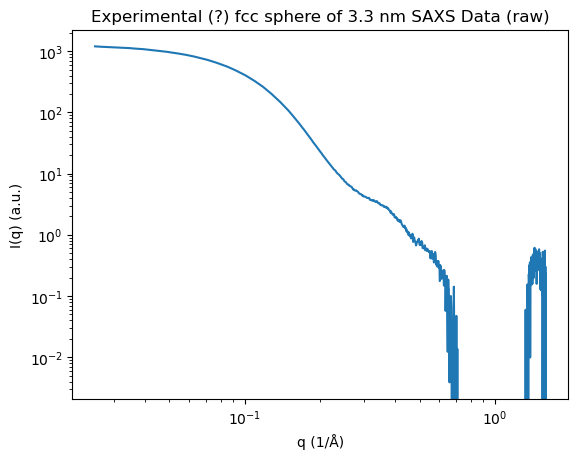

In [24]:
### plot without processing
path = "APH136-B-Pentane_Img062-067_I(q).dat"
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]

plt.loglog(q_exp, I_exp, label='experimental data raw')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental (?) fcc sphere of 3.3 nm SAXS Data (raw)')

### Comparaison with debye calculated curve (not that intersting)

In [75]:

# # Experimental data preprocess
# path = "APH136-B-Pentane_Img062-067_I(q).dat"
# data_exp = np.loadtxt(path)
# q_exp = data_exp[:, 0]
# I_exp = data_exp[:, 1]
# q_exp = q_exp[q_exp < 0.6]      
# I_exp = I_exp[:len(q_exp)]  # keep only the same number of points in I_exp
# print("q_exp length",  len(q_exp))
# print("I_exp length", len(I_exp))

# q_saxs_min = 0.001
# q_saxs_max = 1.6
# saxs_length = 1600-1  # 1599
# q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
# I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

# mask = np.zeros(saxs_length)
# # put 1 where I_exp_interp > 0  :
# for i in range(1, saxs_length - 1):
#     if I_exp_interp[i] > 0 :
#         mask[i] = 1

# I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

#           # (1, 1599)
# for i in range(I_exp_interp.shape[0]):
#     # Indices où le masque est actif
#     idx = np.where(mask > 0)[0]
#     I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
#     mean = np.mean(I_exp_interp[i, idx])
#     print('mean'    , mean)
#     std = np.std(I_exp_interp[i, idx])
#     print('std', std)
#     if std > 0:
#         I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
#     else:
#         I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center



# # DEBYE PREPROCESS
# path = 'SphericalAuNP_3nm.xyz'
# calc = DebyeCalculator(qmin=0.02, qmax=1.6, qstep=0.001, qdamp=0.0, biso=0.0)
# q, iq = calc.iq(path)
# q = q
# iq = iq
# # log
# iq = np.log10(iq)
# # standardize
# mean = np.mean(iq)
# std = np.std(iq)
# iq = (iq - mean) / std
# q_saxs_debye = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
# I_exp_interp_debye = np.interp(q_saxs, q, iq, left=0, right=0)

# # Plot both
# plt.plot( q_saxs_debye, I_exp_interp_debye, label = f'Debye curve')
# plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
# plt.xlabel('q (1/Å)')
# plt.ylabel('I(q) (a.u.)')
# plt.title('Experimental and simulated (Debye Calculator) intensities of (?) fcc sphere of 3  nm')
# plt.legend()
# plt.show()

#### Compare with actual simulated data from the database


q_exp length 365
I_exp length 365
mean 0.9272089169799059
std 1.0830655970330008
Processing file index: 45
iq_saxs_simu (should be a list of 1599 values):  [9.70146382e+09 9.69577958e+09 9.68645110e+09 ... 3.14457914e+04
 3.14556400e+04 3.14814492e+04]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  599
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 599)
mean 7.289916244393896
std 1.3338072752992687
I_exp_interp_simu 2.021972045025258


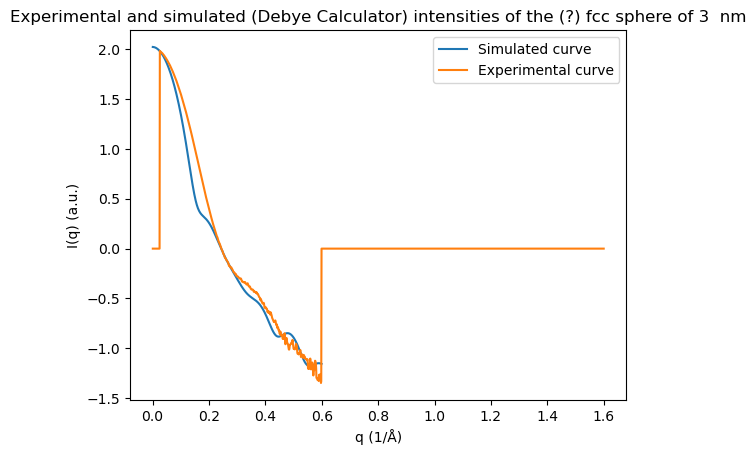

In [74]:
import os
from debyecalculator import DebyeCalculator
import numpy as np
import matplotlib.pyplot as plt

# EXPERIMENTAL PREPROCESS
saxs_length = 1600-1  # 1599
path = "APH136-B-Pentane_Img062-067_I(q).dat"
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]
q_exp = q_exp[q_exp < 0.6]      
I_exp = I_exp[:len(q_exp)]  # keep only the same number of points in I_exp
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))

q_saxs_min = 0.001
q_saxs_max = 1.6
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)

# Experiemental
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1

I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

          # (1, 1599)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
    mean = np.mean(I_exp_interp[i, idx])
    print('mean'    , mean)

    std = np.std(I_exp_interp[i, idx])
    print('std', std)
    if std > 0:
        I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
    else:
        I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center


for index_file in [45]:  # files to test
    print(f'Processing file index: {index_file}')
    # Simualated data from the training dataset directly 
    iq_saxs_simu = np.load('iq_saxs_sphere_fcc_3nm_polydisp2g.npy', allow_pickle = True)  
    iq_saxs_simu = iq_saxs_simu[index_file] # take one file
    print('iq_saxs_simu (should be a list of 1599 values): ', iq_saxs_simu)
    print('iq_saxs_simu shape ( 1599): ', iq_saxs_simu.shape)  # (1599)
    # Make the same preprocessing as experimental data
    for i in range(0, saxs_length ):
        if iq_saxs_simu[i] > 0 :
            mask[i] = 1
    
    # Reshape simulated data to (1, 1599)
    I_exp_interp_simu = iq_saxs_simu.reshape(1, saxs_length)  # (1, 1599)
    # Select only q < 0.6 for both q_saxs and I_exp_interp_simu
    mask_q = q_saxs < 0.6
    q_saxs_selected = q_saxs[mask_q]  # (599,)
    I_exp_interp_simu_selected = I_exp_interp_simu[:, mask_q]  # (1, 599)
    print('q_saxs length after taking q < 0.6 (should be 599): ',  len(q_saxs_selected))  # 599
    print('I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599): ', I_exp_interp_simu_selected.shape)  # (1, 599)
    # Use I_exp_interp_simu_selected for further processing
    I_exp_interp_simu = I_exp_interp_simu_selected


    for i in range(I_exp_interp_simu.shape[0]):
        # Indices où le masque est actif
        idx = np.where(mask > 0)[0]
        idx = idx[idx < I_exp_interp_simu.shape[1]]  # ensure idx is within bounds
        I_exp_interp_simu[i, idx] = np.log10(I_exp_interp_simu[i, idx])
        mean = np.mean(I_exp_interp_simu[i, idx])
        print('mean'    , mean)
        std = np.std(I_exp_interp_simu[i, idx])
        print('std', std)
        if std > 0:
            I_exp_interp_simu[i, idx] = (I_exp_interp_simu[i, idx] - mean) / std
        else:
            I_exp_interp_simu[i, idx] = I_exp_interp_simu[i, idx] - mean  # if std = 0, just center

    print('I_exp_interp_simu', I_exp_interp_simu[0, 0])

    # I_exp_interp_simu has shape (1, 1599) but should be (1599,)
    I_exp_interp_simu = I_exp_interp_simu.flatten()  # (1599,)

    # Plot both
    plt.plot(q_saxs_selected, I_exp_interp_simu, label = f'Simulated curve')
    plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
    plt.xlabel('q (1/Å)')
    plt.ylabel('I(q) (a.u.)')
    plt.title('Experimental and simulated (Debye Calculator) intensities of the (?) fcc sphere of 3  nm')
    plt.legend()
    plt.show()

### Ag ico of 3 nm

Predicted global size (Å):  [27.882736]
Predicted shape: ['cube']

Text(0.5, 1.0, 'Experimental Ag ico of 3 nm SAXS Data (raw)')

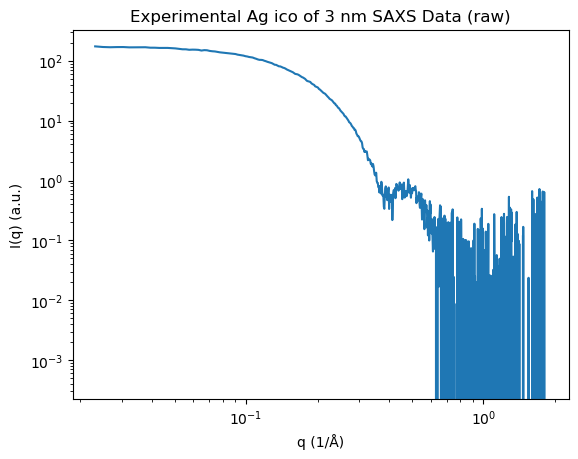

In [10]:
### plot without processing
path = "Ag_OY_10_radial_profile.dat"
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]

plt.loglog(q_exp, I_exp, label='experimental data raw')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental Ag ico of 3 nm SAXS Data (raw)')


q_exp length 1000
I_exp length 1000
mean 0.1438570679928409
std 1.223042703033638


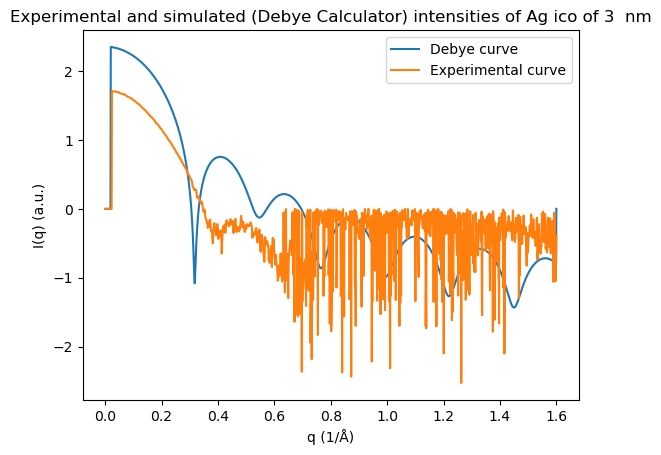

In [11]:


path = "Ag_OY_10_radial_profile.dat"
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))

q_saxs_min = 0.001
q_saxs_max = 1.6
saxs_length = 1600-1  # 1599
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1

I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

          # (1, 1599)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
    mean = np.mean(I_exp_interp[i, idx])
    print('mean'    , mean)
    std = np.std(I_exp_interp[i, idx])
    print('std', std)
    if std > 0:
        I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
    else:
        I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center



# DEBYE PREPROCESS

path = 'ico_2.xyz'
calc = DebyeCalculator(qmin=0.02, qmax=1.6, qstep=0.001, qdamp=0.0, biso=0.0)
q, iq = calc.iq(path)
q = q
iq = iq
# log
iq = np.log10(iq)
# standardize
mean = np.mean(iq)
std = np.std(iq)
iq = (iq - mean) / std
q_saxs_debye = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp_debye = np.interp(q_saxs, q, iq, left=0, right=0)

# Plot both
plt.plot( q_saxs_debye, I_exp_interp_debye, label = f'Debye curve')
plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental and simulated (Debye Calculator) intensities of Ag ico of 3  nm')
plt.legend()
plt.show()

### Au octahedron 4 nm (data not really good)
Predicted global size (Å):  [31.901579]
Predicted shape: ['cube']

Text(0.5, 1.0, 'Experimental Au octahedral 4 nm SAXS Data (raw)')

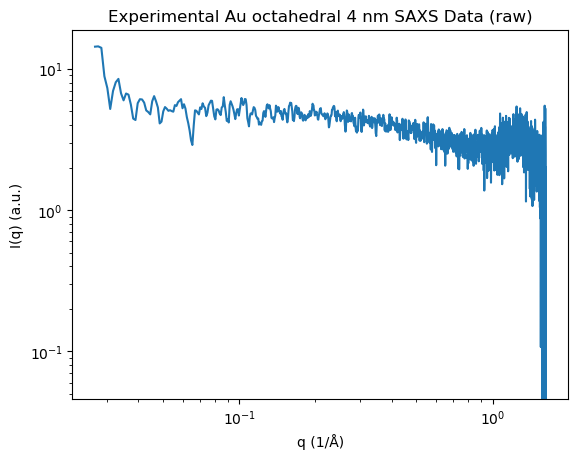

In [77]:
### plot without processing
path = 'Auform_toluene_Img003-005_I(q).dat'

data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]

plt.loglog(q_exp, I_exp, label='experimental data raw')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental Au octahedral 4 nm SAXS Data (raw)')

q_exp length 2000
I_exp length 2000
mean 0.5199216668655884
std 0.1375544303982251


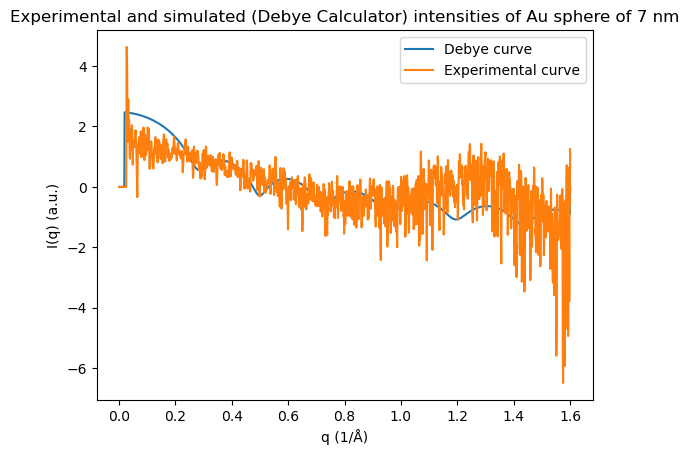

In [6]:
import os
from debyecalculator import DebyeCalculator
import numpy as np
import matplotlib.pyplot as plt
# EXPEIRMENTAL PREPROCESS



path = "Auform_toluene_Img003-005_I(q).dat"
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))

q_saxs_min = 0.001
q_saxs_max = 1.6
saxs_length = 1600-1  # 1599
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1

I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

          # (1, 1599)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
    mean = np.mean(I_exp_interp[i, idx])
    print('mean'    , mean)
    std = np.std(I_exp_interp[i, idx])
    print('std', std)
    if std > 0:
        I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
    else:
        I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center



# DEBYE PREPROCESS

path = 'fccOh.xyz'
calc = DebyeCalculator(qmin=0.02, qmax=1.6, qstep=0.001, qdamp=0.0, biso=0.0)
q, iq = calc.iq(path)
q = q
iq = iq
# log
iq = np.log10(iq)
# standardize
mean = np.mean(iq)
std = np.std(iq)
iq = (iq - mean) / std
q_saxs_debye = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp_debye = np.interp(q_saxs, q, iq, left=0, right=0)

# Plot both
plt.plot( q_saxs_debye, I_exp_interp_debye, label = f'Debye curve')
plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental and simulated (Debye Calculator) intensities of Au sphere of 7 nm')
plt.legend()
plt.show()

### Au sphere 14 nm


#### Debye vs experimental preprocess : becareful remake debye with right size and also the CNN wasn't trained on that kinda sizes

Text(0.5, 1.0, 'Experimental Au sphere 7 nm SAXS Data (raw)')

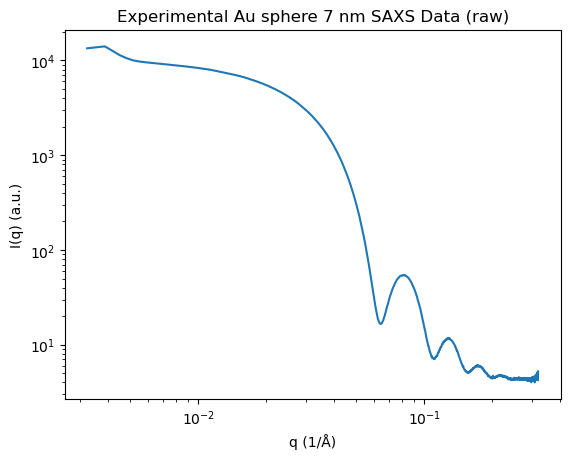

In [78]:
### plot without processing
path = 'Au_sphere_7nm.txt'

data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]

plt.loglog(q_exp, I_exp, label='experimental data raw')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental Au sphere 7 nm SAXS Data (raw)')

q_exp length 1000
I_exp length 1000
mean 1.2788430956410934
std 0.9923088769455204


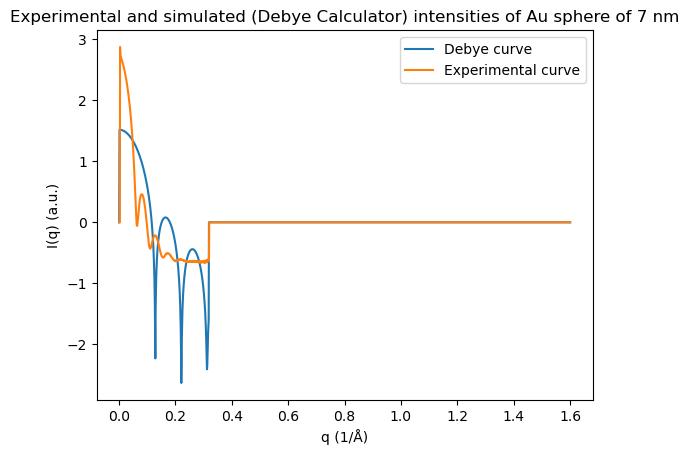

In [5]:
import os
from debyecalculator import DebyeCalculator
import numpy as np
import matplotlib.pyplot as plt
# EXPEIRMENTAL PREPROCESS



path = f'Au_sphere_7nm.txt'
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))

q_saxs_min = 0.001
q_saxs_max = 1.6
saxs_length = 1600-1  # 1599
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1

I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

          # (1, 1599)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
    mean = np.mean(I_exp_interp[i, idx])
    print('mean'    , mean)
    std = np.std(I_exp_interp[i, idx])
    print('std', std)
    if std > 0:
        I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
    else:
        I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center



# DEBYE PREPROCESS

path = 'SphericalAuNP.xyz'
calc = DebyeCalculator(qmin=0.001, qmax=0.32, qstep=0.001, qdamp=0.0, biso=0.0)
q, iq = calc.iq(path)
q = q
iq = iq
# log
iq = np.log10(iq)
# standardize
mean = np.mean(iq)
std = np.std(iq)
iq = (iq - mean) / std
q_saxs_debye = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp_debye = np.interp(q_saxs, q, iq, left=0, right=0)

# Plot both
plt.plot( q_saxs_debye, I_exp_interp_debye, label = f'Debye curve')
plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental and simulated (Debye Calculator) intensities of Au sphere of 7 nm')
plt.legend()
plt.show()

### Ag ico 7 shells 3.6 nm - 4 nm

### Debye preprocess vs Experimental preprocess

Predicted global size (Å):  33 or 30 if we change the q interval 
Predicted shape: ['regIco']

Text(0.5, 1.0, 'Experimental Ag ico 7 shells SAXS Data (raw)')

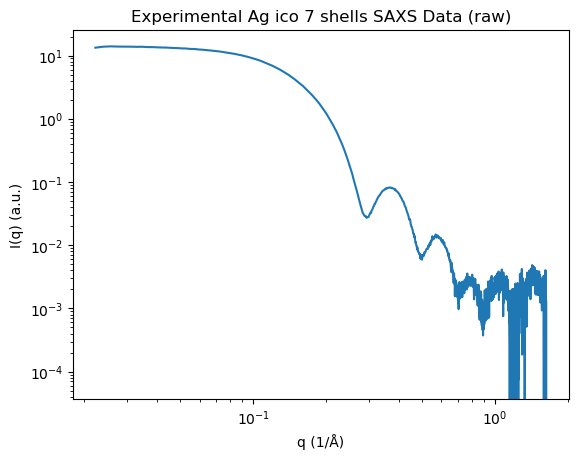

In [79]:
### plot without processing
path = 'Ag_ico_7shells.txt'
# path = 'Au_sphere_7nm.txt'
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]

plt.loglog(q_exp, I_exp, label='experimental data raw')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental Ag ico 7 shells SAXS Data (raw)')

q_exp length 606
I_exp length 606
mean -1.6046094050766868
std 1.2692459482165248


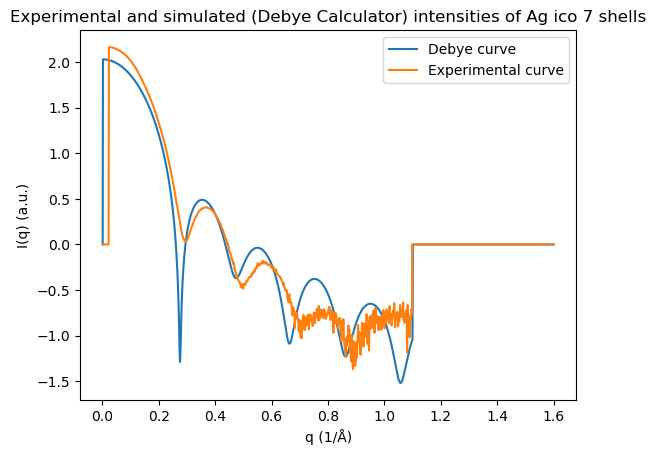

In [ ]:
import os
from debyecalculator import DebyeCalculator

# EXPEIRMENTAL PREPROCESS

path = 'Ag_ico_7shells.txt'
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]
q_exp = q_exp[q_exp < 1.1]
I_exp = I_exp[:len(q_exp)]  # keep only the same number of points in I_exp
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))

q_saxs_min = 0.001
q_saxs_max = 1.6
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1

I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

          # (1, 1599)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
    mean = np.mean(I_exp_interp[i, idx])
    print('mean'    , mean)

    std = np.std(I_exp_interp[i, idx])
    print('std', std)
    if std > 0:
        I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
    else:
        I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center



# DEBYE PREPROCESS

path = f'ico.xyz'

calc = DebyeCalculator(qmin=0.001, qmax=1.1, qstep=0.001, qdamp=0.0, biso=0.0)
q, iq = calc.iq(path)
q = q
iq = iq
# log
iq = np.log10(iq)
# standardize
mean = np.mean(iq)
std = np.std(iq)
iq = (iq - mean) / std
q_saxs_debye = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
I_exp_interp_debye = np.interp(q_saxs, q, iq, left=0, right=0)
 




# Plot both
plt.plot( q_saxs_debye, I_exp_interp_debye, label = f'Debye curve')
plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q) (a.u.)')
plt.title('Experimental and simulated (Debye Calculator) intensities of Ag ico 7 shells')
plt.legend()
plt.show()


In [92]:
from debyecalculator import DebyeCalculator
from matplotlib import pyplot as plt
import numpy as np


file = 'CoWire.xyz'

calc = DebyeCalculator(qmin=0.001, qmax=1.6, qstep=0.001, qdamp=0.0, biso=0.0)
q, iq = calc.iq(file)
print(q)
print(iq)
np.savetxt('CoWire_Iq_2.txt', np.column_stack((q, iq)))

[1.0000000e-03 2.0000001e-03 3.0000000e-03 ... 1.5980000e+00 1.5990001e+00
 1.6000000e+00]
[8.5946733e+08 8.5912826e+08 8.5856358e+08 ... 5.9400562e+04 5.9828719e+04
 6.0232656e+04]


### Compare it to actual simulated data from the training dataset but not Ag 

q_exp length 904
I_exp length 904
mean -1.9668842432609195
std 1.196650069430214
Processing file index: 0
iq_saxs_simu (should be a list of 1599 values):  [2.56616940e+10 2.56541123e+10 2.56415130e+10 ... 3.89245000e+05
 3.89590500e+05 3.89623500e+05]
iq_saxs_simu shape ( 1599):  (1599,)
mean 6.588731461335074
std 1.4430865891990077
I_exp_interp_simu 2.647487606373331


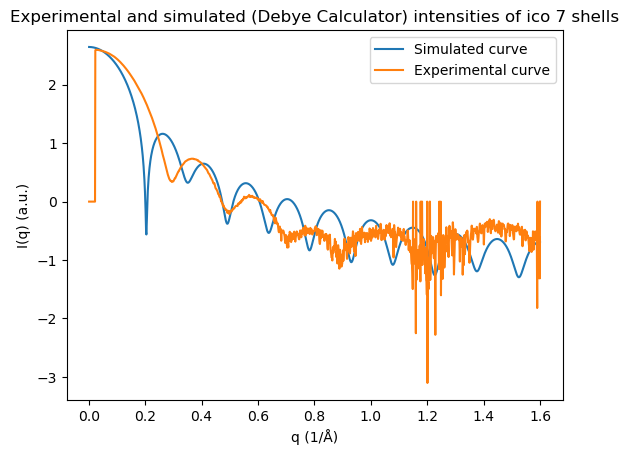

Processing file index: 15
iq_saxs_simu (should be a list of 1599 values):  [1.90669896e+10 1.90601857e+10 1.90490442e+10 ... 1.55494778e+05
 1.54270950e+05 1.53077563e+05]
iq_saxs_simu shape ( 1599):  (1599,)
mean 6.447302363524654
std 1.4142148596494322
I_exp_interp_simu 2.7103234985832585


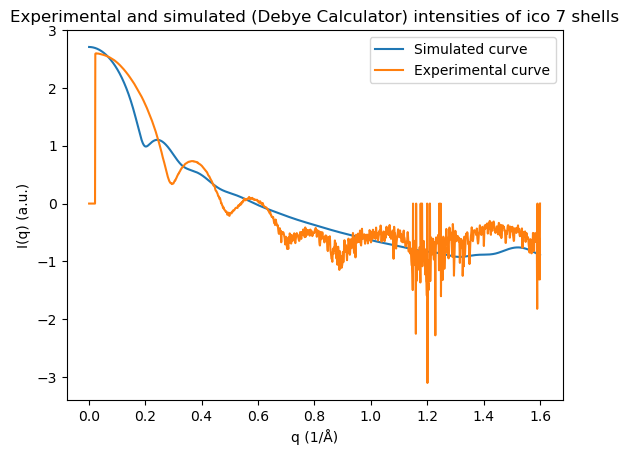

Processing file index: 25
iq_saxs_simu (should be a list of 1599 values):  [2.56616940e+10 2.56541123e+10 2.56415130e+10 ... 3.89245000e+05
 3.89590500e+05 3.89623500e+05]
iq_saxs_simu shape ( 1599):  (1599,)
mean 6.588731461335074
std 1.4430865891990077
I_exp_interp_simu 2.647487606373331


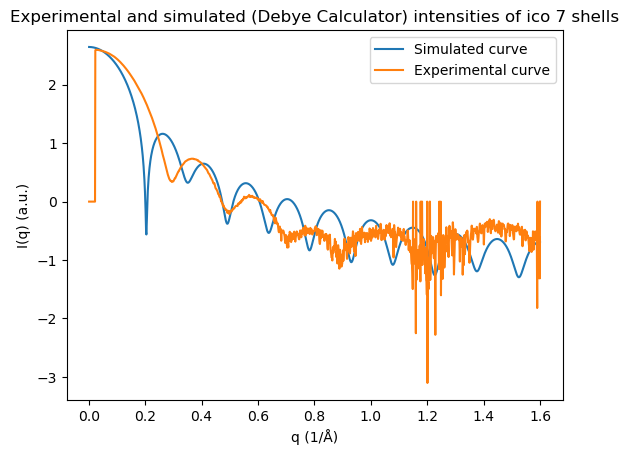

Processing file index: 35
iq_saxs_simu (should be a list of 1599 values):  [8.72833024e+09 8.72552550e+09 8.72089600e+09 ... 1.69182500e+04
 1.61758750e+04 1.54947500e+04]
iq_saxs_simu shape ( 1599):  (1599,)
mean 5.991553538405105
std 1.491604080342609
I_exp_interp_simu 2.6477385542489325


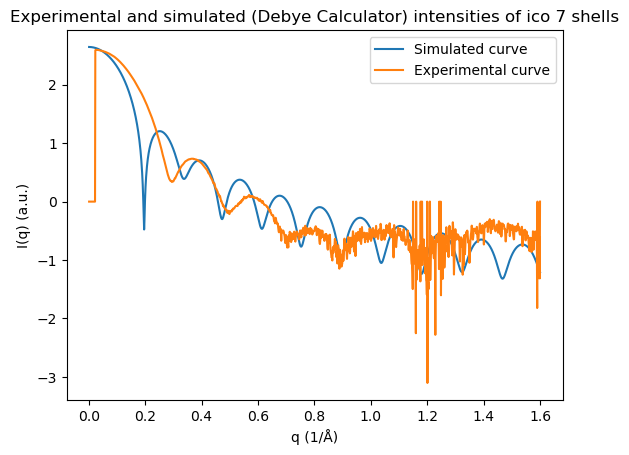

Processing file index: 45
iq_saxs_simu (should be a list of 1599 values):  [1.01953158e+10 1.01920783e+10 1.01866973e+10 ... 1.32740133e+05
 1.32595191e+05 1.32350255e+05]
iq_saxs_simu shape ( 1599):  (1599,)
mean 6.232275493923699
std 1.414326742331859
I_exp_interp_simu 2.6699100539271243


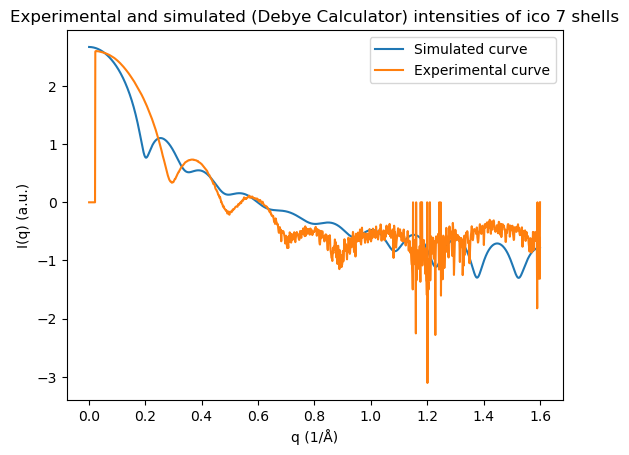

Processing file index: 55
iq_saxs_simu (should be a list of 1599 values):  [1.69087692e+10 1.69031470e+10 1.68942030e+10 ... 1.71428506e+05
 1.70138378e+05 1.68855763e+05]
iq_saxs_simu shape ( 1599):  (1599,)
mean 6.43589848993541
std 1.4038176747951676
I_exp_interp_simu 2.701357571960701


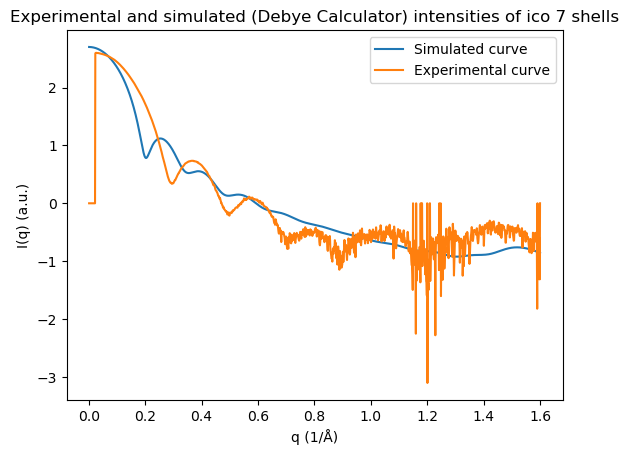

Processing file index: 65
iq_saxs_simu (should be a list of 1599 values):  [1.61705112e+10 1.61654701e+10 1.61574232e+10 ... 2.71462784e+05
 2.68889747e+05 2.66292012e+05]
iq_saxs_simu shape ( 1599):  (1599,)
mean 6.439731625708346
std 1.3822570580895222
I_exp_interp_simu 2.726694069428625


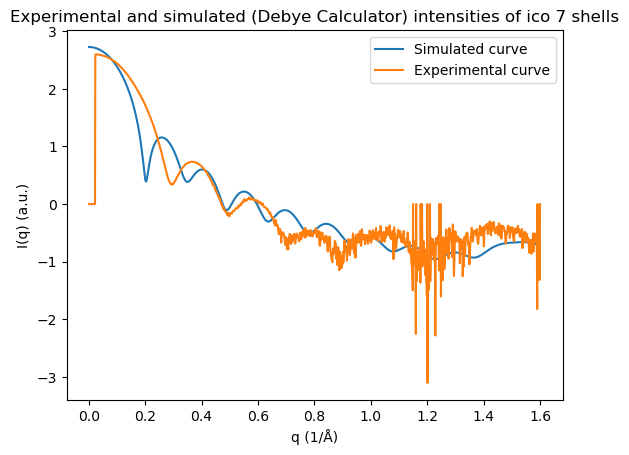

Processing file index: 75
iq_saxs_simu (should be a list of 1599 values):  [2.54197279e+10 2.54084327e+10 2.53913191e+10 ... 1.54753614e+05
 1.53323307e+05 1.51938116e+05]
iq_saxs_simu shape ( 1599):  (1599,)
mean 6.4663207421735995
std 1.4277643965965485
I_exp_interp_simu 2.758753590733587


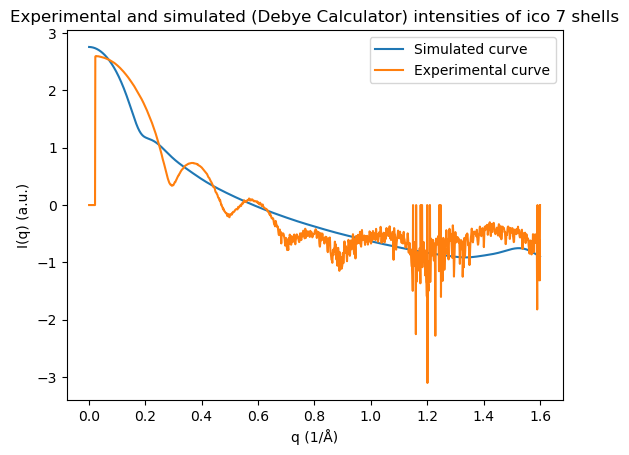

In [63]:
import os
from debyecalculator import DebyeCalculator
import numpy as np
import matplotlib.pyplot as plt

# EXPERIMENTAL PREPROCESS
saxs_length = 1600-1  # 1599
path = 'Ag_ico_7shells.txt'
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))

q_saxs_min = 0.001
q_saxs_max = 1.6
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)

# Experiemental
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1

I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

          # (1, 1599)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
    mean = np.mean(I_exp_interp[i, idx])
    print('mean'    , mean)

    std = np.std(I_exp_interp[i, idx])
    print('std', std)
    if std > 0:
        I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
    else:
        I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center


for index_file in [0, 15, 25, 35, 45, 55, 65, 75]:  # files to test
    print(f'Processing file index: {index_file}')
    # Simualated data from the training dataset directly 
    iq_saxs_simu = np.load('iq_saxs_ico_25A_polydisperse_3.npy', allow_pickle = True)  
    iq_saxs_simu = iq_saxs_simu[index_file] # take one file
    print('iq_saxs_simu (should be a list of 1599 values): ', iq_saxs_simu)
    print('iq_saxs_simu shape ( 1599): ', iq_saxs_simu.shape)  # (1599)
    # Make the same preprocessing as experimental data
    for i in range(0, saxs_length ):
        if iq_saxs_simu[i] > 0 :
            mask[i] = 1
    
    I_exp_interp_simu = iq_saxs_simu.reshape(1, 1599)  # (1, 1599)
    for i in range(I_exp_interp_simu.shape[0]):
        # Indices où le masque est actif
        idx = np.where(mask > 0)[0]
        I_exp_interp_simu[i, idx] = np.log10(I_exp_interp_simu[i, idx])
        mean = np.mean(I_exp_interp_simu[i, idx])
        print('mean'    , mean)
        std = np.std(I_exp_interp_simu[i, idx])
        print('std', std)
        if std > 0:
            I_exp_interp_simu[i, idx] = (I_exp_interp_simu[i, idx] - mean) / std
        else:
            I_exp_interp_simu[i, idx] = I_exp_interp_simu[i, idx] - mean  # if std = 0, just center

    print('I_exp_interp_simu', I_exp_interp_simu[0, 0])

    # I_exp_interp_simu has shape (1, 1599) but should be (1599,)
    I_exp_interp_simu = I_exp_interp_simu.flatten()  # (1599,)

    # Plot both
    plt.plot(q_saxs, I_exp_interp_simu, label = f'Simulated curve')
    plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
    plt.xlabel('q (1/Å)')
    plt.ylabel('I(q) (a.u.)')
    plt.title('Experimental and simulated (Debye Calculator) intensities of ico 7 shells')
    plt.legend()
    plt.show()

q_exp length 606
I_exp length 606
mean -1.6046094050766868
std 1.2692459482165248
Processing file index: 1
iq_saxs_simu (should be a list of 1599 values):  [1.14652104e+08 1.14614336e+08 1.14551416e+08 ... 4.55628531e+05
 4.49153938e+05 4.42674406e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 4.893978444703918
std 1.2877886998396044
I_exp_interp_simu 2.4580147229435525


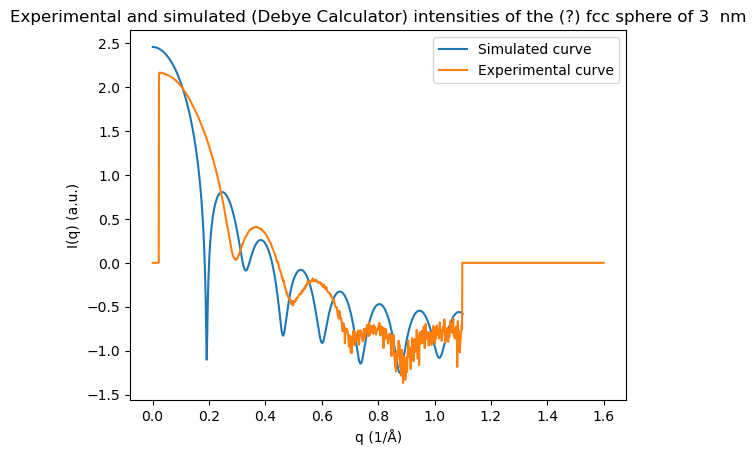

Processing file index: 2
iq_saxs_simu (should be a list of 1599 values):  [2.45973381e+10 2.45897953e+10 2.45779866e+10 ... 1.78084000e+05
 1.77588500e+05 1.76985000e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 7.043327663491441
std 1.484132196444987
I_exp_interp_simu 2.2555675669990554


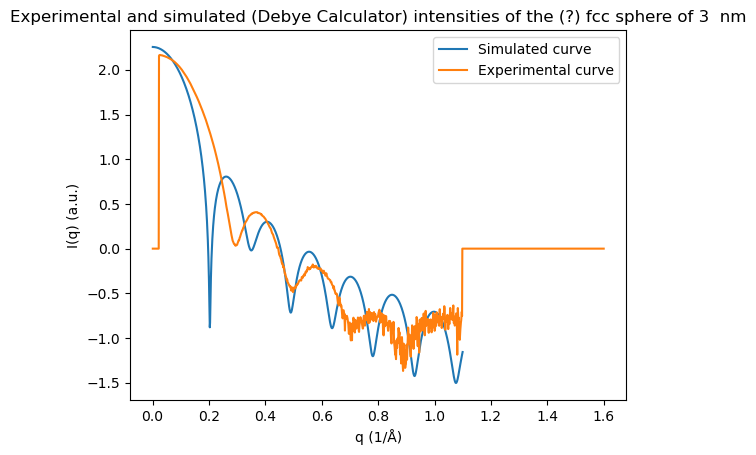

Processing file index: 3
iq_saxs_simu (should be a list of 1599 values):  [8.72833024e+09 8.72552550e+09 8.72089600e+09 ... 1.69182500e+04
 1.61758750e+04 1.54947500e+04]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.5577832856101885
std 1.4689188769185213
I_exp_interp_simu 2.303155019077832


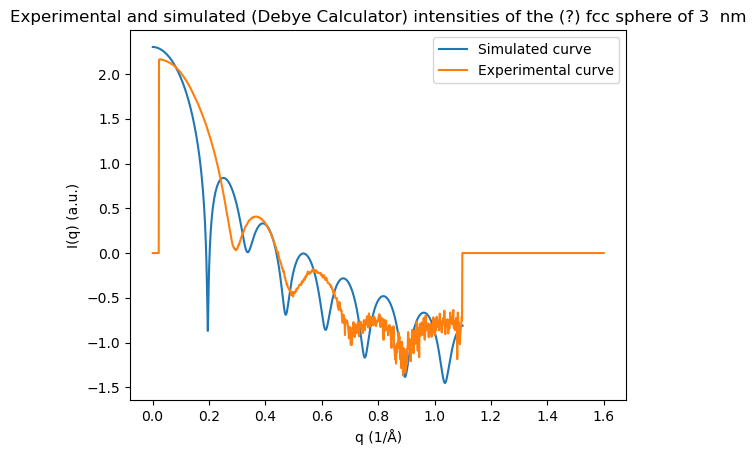

Processing file index: 4
iq_saxs_simu (should be a list of 1599 values):  [4.12091556e+10 4.11974615e+10 4.11781612e+10 ... 1.85706000e+05
 1.91833000e+05 1.97949500e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 7.328497972934521
std 1.460016415587515
I_exp_interp_simu 2.250999171977818


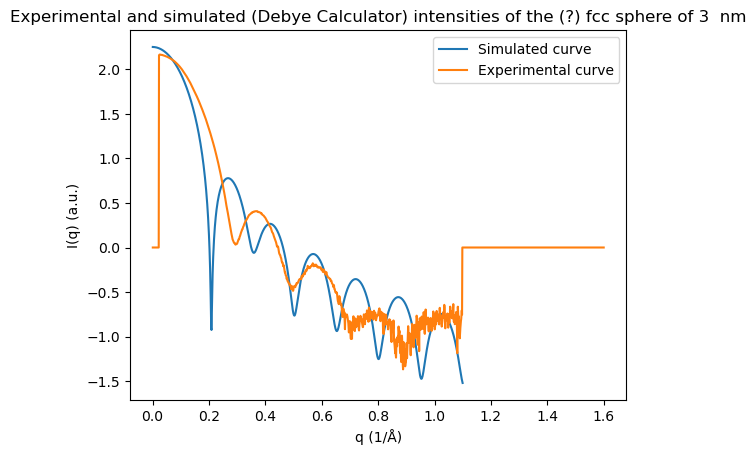

Processing file index: 5
iq_saxs_simu (should be a list of 1599 values):  [1.07940790e+10 1.07908689e+10 1.07855337e+10 ... 1.61567303e+05
 1.61683760e+05 1.61671139e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.7611998282214225
std 1.4260477867221355
I_exp_interp_simu 2.2944432806845385


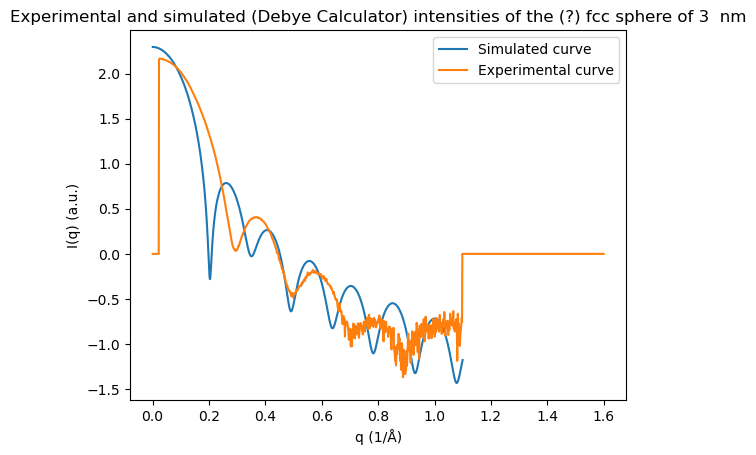

Processing file index: 6
iq_saxs_simu (should be a list of 1599 values):  [1.01953158e+10 1.01920783e+10 1.01866973e+10 ... 1.32740133e+05
 1.32595191e+05 1.32350255e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.78682394738782
std 1.3737644011043244
I_exp_interp_simu 2.3450722211435866


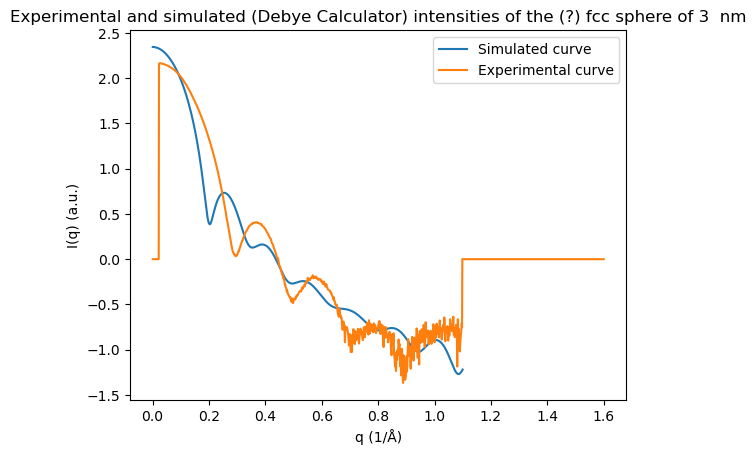

Processing file index: 7
iq_saxs_simu (should be a list of 1599 values):  [1.12835253e+10 1.12796262e+10 1.12731665e+10 ... 1.24865734e+05
 1.24490353e+05 1.24029774e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.806572508112202
std 1.3741480298158881
I_exp_interp_simu 2.362097989068422


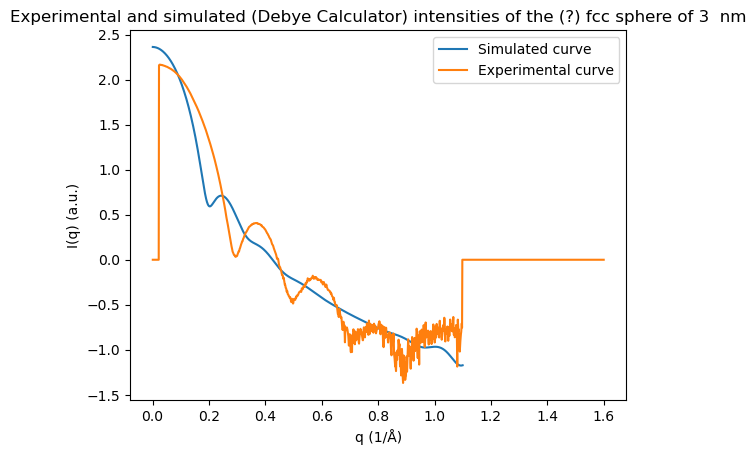

Processing file index: 8
iq_saxs_simu (should be a list of 1599 values):  [1.50701545e+10 1.50637371e+10 1.50530410e+10 ... 1.08659115e+05
 1.07947397e+05 1.07188934e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.830425961232197
std 1.388397044094093
I_exp_interp_simu 2.411191927169449


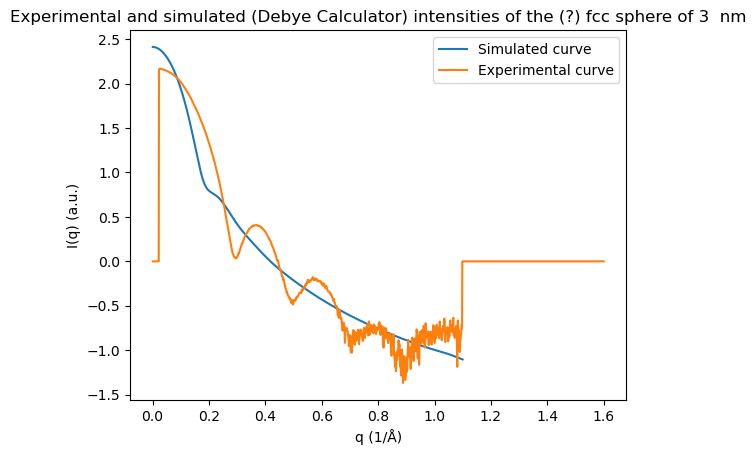

Processing file index: 9
iq_saxs_simu (should be a list of 1599 values):  [1.58449284e+10 1.58400253e+10 1.58321976e+10 ... 2.71569610e+05
 2.68927406e+05 2.66260535e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.935570742325799
std 1.4043575945178153
I_exp_interp_simu 2.3244218931375062


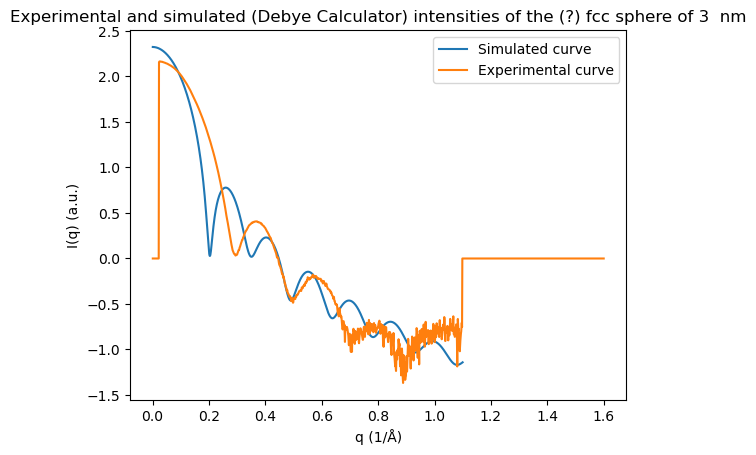

Processing file index: 10
iq_saxs_simu (should be a list of 1599 values):  [1.69087692e+10 1.69031470e+10 1.68942030e+10 ... 1.71428506e+05
 1.70138378e+05 1.68855763e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.971665082869983
std 1.395273306554741
I_exp_interp_simu 2.3339132894089074


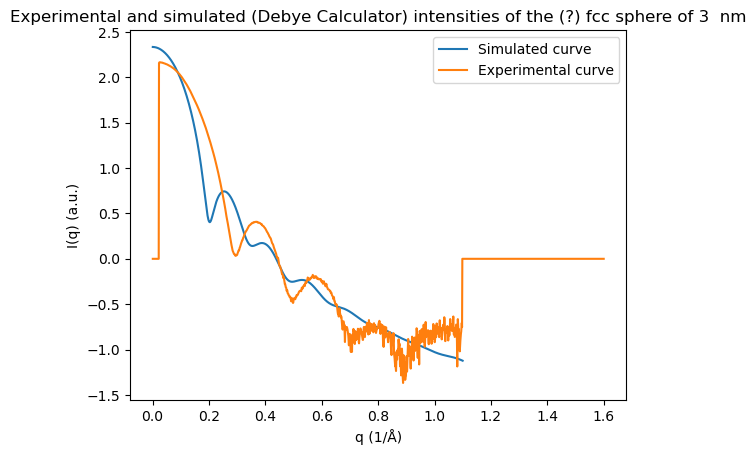

Processing file index: 11
iq_saxs_simu (should be a list of 1599 values):  [1.87122423e+10 1.87055989e+10 1.86947315e+10 ... 1.54497827e+05
 1.53279194e+05 1.52090136e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.9857142347531695
std 1.4027235025705949
I_exp_interp_simu 2.3428791139253833


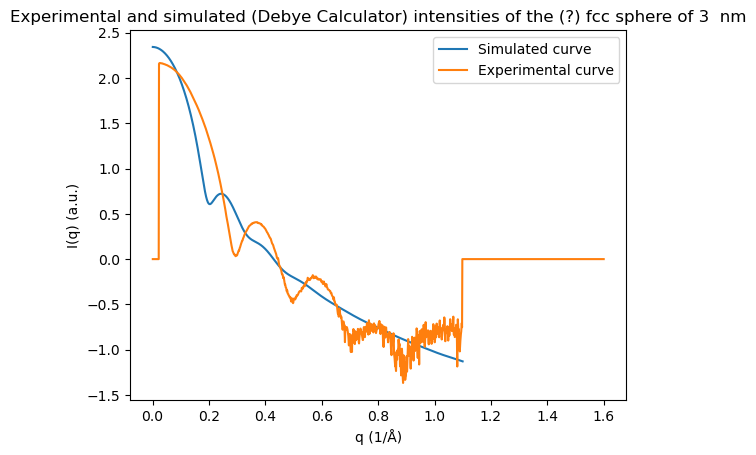

Processing file index: 12
iq_saxs_simu (should be a list of 1599 values):  [2.49875378e+10 2.49764960e+10 2.49597202e+10 ... 1.53677514e+05
 1.52263825e+05 1.50894578e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 7.007360738260149
std 1.4195040026300145
I_exp_interp_simu 2.3884136433746903


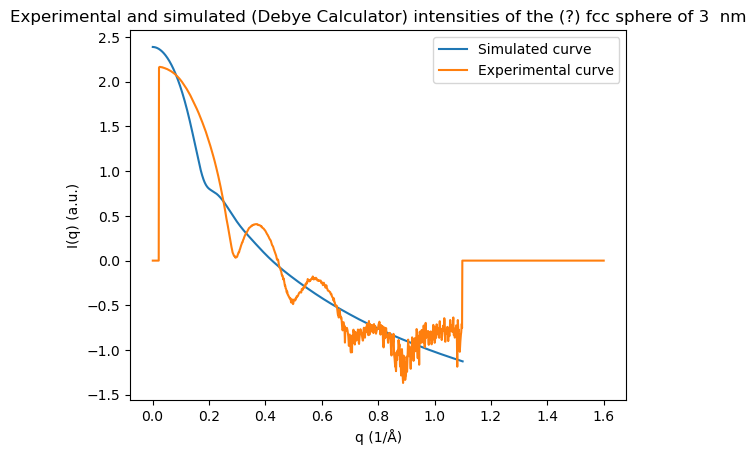

Processing file index: 13
iq_saxs_simu (should be a list of 1599 values):  [1.61705112e+10 1.61654701e+10 1.61574232e+10 ... 2.71462784e+05
 2.68889747e+05 2.66292012e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.939214829662797
std 1.4048654991287726
I_exp_interp_simu 2.327275401660652


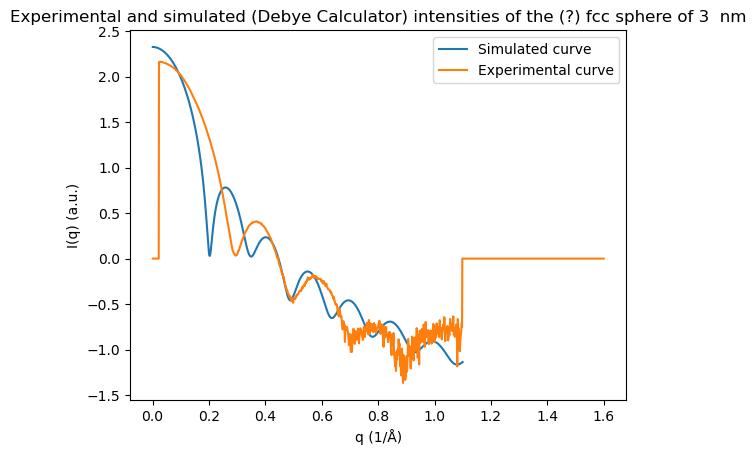

Processing file index: 14
iq_saxs_simu (should be a list of 1599 values):  [1.72398329e+10 1.72340571e+10 1.72248755e+10 ... 1.72108899e+05
 1.70847455e+05 1.69594104e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.974805107199093
std 1.3959931631285674
I_exp_interp_simu 2.3364927791038177


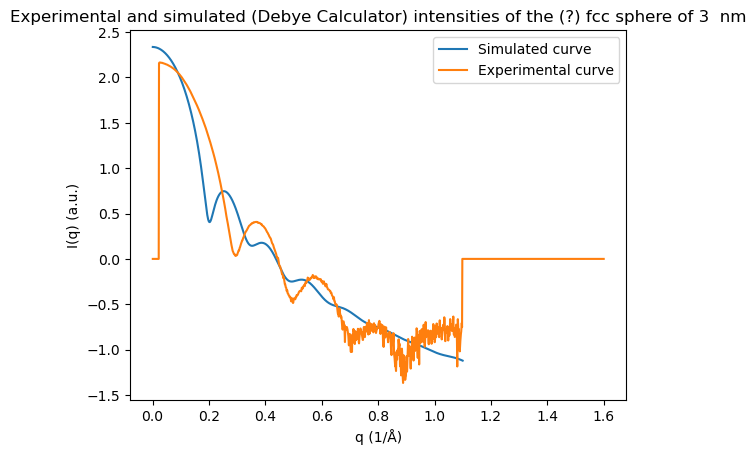

Processing file index: 16
iq_saxs_simu (should be a list of 1599 values):  [2.54197279e+10 2.54084327e+10 2.53913191e+10 ... 1.54753614e+05
 1.53323307e+05 1.51938116e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 7.010373946878651
std 1.4201056899651485
I_exp_interp_simu 2.3905241526146996


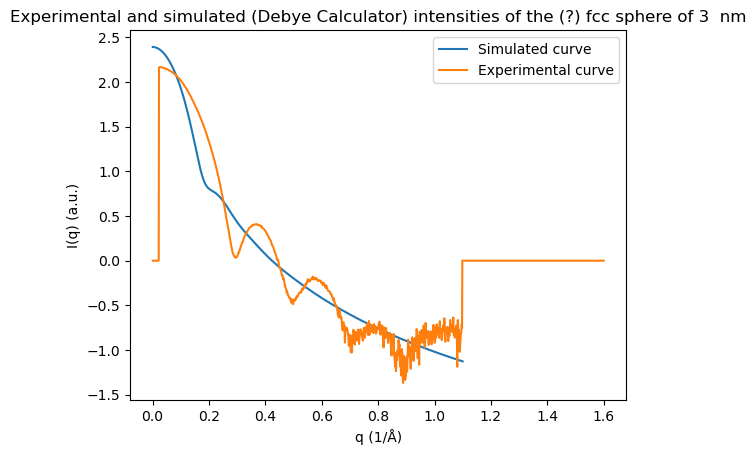

Processing file index: 45
iq_saxs_simu (should be a list of 1599 values):  [1.01953158e+10 1.01920783e+10 1.01866973e+10 ... 1.32740133e+05
 1.32595191e+05 1.32350255e+05]
iq_saxs_simu shape ( 1599):  (1599,)
q_saxs length after taking q < 0.6 (should be 599):  1099
I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599):  (1, 1099)
mean 6.78682394738782
std 1.3737644011043244
I_exp_interp_simu 2.3450722211435866


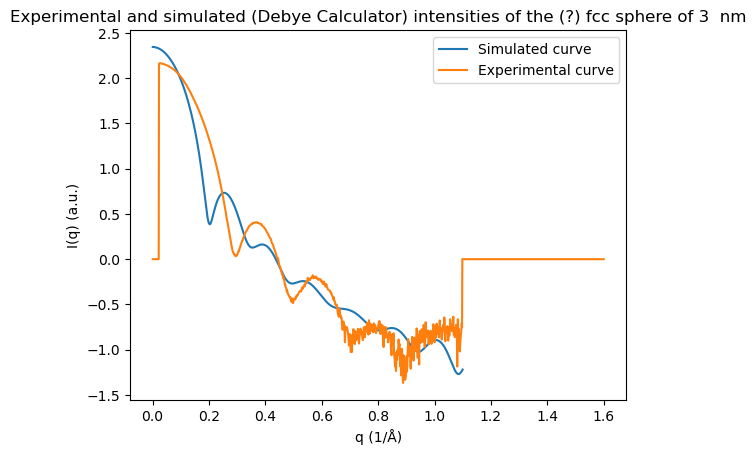

In [79]:
import os
from debyecalculator import DebyeCalculator
import numpy as np
import matplotlib.pyplot as plt

# EXPERIMENTAL PREPROCESS
saxs_length = 1600-1  # 1599
path = 'Ag_ico_7shells.txt'
data_exp = np.loadtxt(path)
q_exp = data_exp[:, 0]
I_exp = data_exp[:, 1]
q_exp = q_exp[q_exp < 1.1]      
I_exp = I_exp[:len(q_exp)]  # keep only the same number of points in I_exp
print("q_exp length",  len(q_exp))
print("I_exp length", len(I_exp))

q_saxs_min = 0.001
q_saxs_max = 1.6
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)

# Experiemental
I_exp_interp = np.interp(q_saxs, q_exp, I_exp, left=0, right=0)

mask = np.zeros(saxs_length)
# put 1 where I_exp_interp > 0  :
for i in range(1, saxs_length - 1):
    if I_exp_interp[i] > 0 :
        mask[i] = 1

I_exp_interp = I_exp_interp.reshape(1, saxs_length)  # (1, 1599)

          # (1, 1599)
for i in range(I_exp_interp.shape[0]):
    # Indices où le masque est actif
    idx = np.where(mask > 0)[0]
    I_exp_interp[i, idx] = np.log10(I_exp_interp[i, idx])
    mean = np.mean(I_exp_interp[i, idx])
    print('mean'    , mean)

    std = np.std(I_exp_interp[i, idx])
    print('std', std)
    if std > 0:
        I_exp_interp[i, idx] = (I_exp_interp[i, idx] - mean) / std
    else:
        I_exp_interp[i, idx] = I_exp_interp[i, idx] - mean  # if std = 0, just center


for index_file in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,45]:  # files to test
    print(f'Processing file index: {index_file}')
    # Simualated data from the training dataset directly 
    iq_saxs_simu = np.load('iq_saxs_ico_25A_polydisperse_3.npy', allow_pickle = True)  
    iq_saxs_simu = iq_saxs_simu[index_file] # take one file
    print('iq_saxs_simu (should be a list of 1599 values): ', iq_saxs_simu)
    print('iq_saxs_simu shape ( 1599): ', iq_saxs_simu.shape)  # (1599)
    # Make the same preprocessing as experimental data
    for i in range(0, saxs_length ):
        if iq_saxs_simu[i] > 0 :
            mask[i] = 1
    
    # Reshape simulated data to (1, 1599)
    I_exp_interp_simu = iq_saxs_simu.reshape(1, saxs_length)  # (1, 1599)
    # Select only q < 0.6 for both q_saxs and I_exp_interp_simu
    mask_q = q_saxs < 1.1
    q_saxs_selected = q_saxs[mask_q]  # (599,)
    I_exp_interp_simu_selected = I_exp_interp_simu[:, mask_q]  # (1, 599)
    print('q_saxs length after taking q < 0.6 (should be 599): ',  len(q_saxs_selected))  # 599
    print('I_exp_interp_simu shape after taking q < 0.6 (should be 1, 599): ', I_exp_interp_simu_selected.shape)  # (1, 599)
    # Use I_exp_interp_simu_selected for further processing
    I_exp_interp_simu = I_exp_interp_simu_selected


    for i in range(I_exp_interp_simu.shape[0]):
        # Indices où le masque est actif
        idx = np.where(mask > 0)[0]
        idx = idx[idx < I_exp_interp_simu.shape[1]]  # ensure idx is within bounds
        I_exp_interp_simu[i, idx] = np.log10(I_exp_interp_simu[i, idx])
        mean = np.mean(I_exp_interp_simu[i, idx])
        print('mean'    , mean)
        std = np.std(I_exp_interp_simu[i, idx])
        print('std', std)
        if std > 0:
            I_exp_interp_simu[i, idx] = (I_exp_interp_simu[i, idx] - mean) / std
        else:
            I_exp_interp_simu[i, idx] = I_exp_interp_simu[i, idx] - mean  # if std = 0, just center

    print('I_exp_interp_simu', I_exp_interp_simu[0, 0])

    # I_exp_interp_simu has shape (1, 1599) but should be (1599,)
    I_exp_interp_simu = I_exp_interp_simu.flatten()  # (1599,)

    # Plot both
    plt.plot(q_saxs_selected, I_exp_interp_simu, label = f'Simulated curve')
    plt.plot(q_saxs, I_exp_interp[0], label = 'Experimental curve')
    plt.xlabel('q (1/Å)')
    plt.ylabel('I(q) (a.u.)')
    plt.title('Experimental and simulated (Debye Calculator) intensities of the (?) fcc sphere of 3  nm')
    plt.legend()
    plt.show()

Processing file index: 1
Processing file index: 2
Processing file index: 3
Processing file index: 4
Processing file index: 14
Processing file index: 16
Processing file index: 45


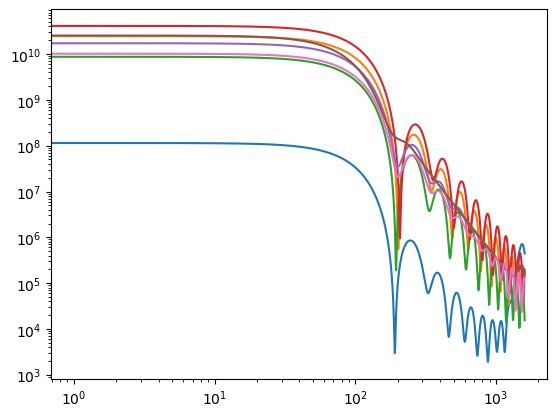

In [82]:
q_saxs_min = 0.001
q_saxs_max = 1.6
saxs_length = 1600-1  # 1599
q_saxs = np.linspace(q_saxs_min, q_saxs_max, saxs_length)
for index_file in [1,2,3,4,14,16,45]:  # files to test
    print(f'Processing file index: {index_file}')
    # Simualated data from the training dataset directly 
    iq_saxs_simu = np.load('iq_saxs_ico_25A_polydisperse_3.npy', allow_pickle = True)  
    iq_saxs_simu = iq_saxs_simu[index_file] # take one file
    plt.loglog(iq_saxs_simu, label = f'Simulated curve index {index_file}')

In [ ]:
### Justifying why we use the std derivative : compare two confused shapes : Oh, trOh then do the mathematical transformations (log, std)

### Justifying why we use the std derivative 
Compare two confused shapes : Oh, trOh then do the mathematical transformations (log, std) and show the std derivative

In [13]:
from debyecalculator import DebyeCalculator

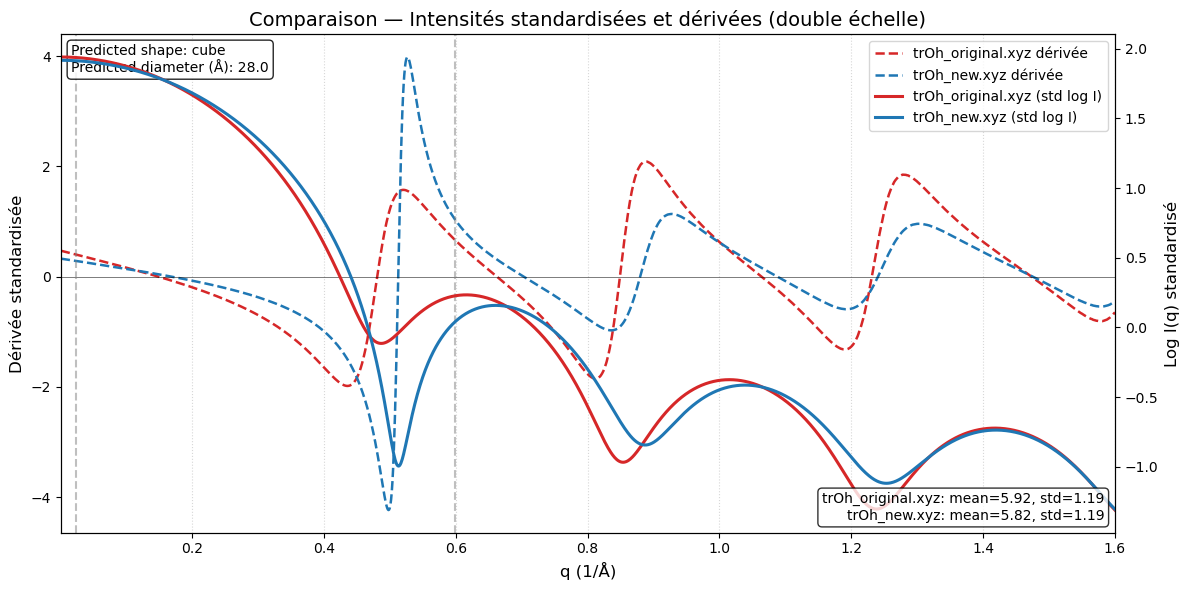

In [39]:
# Graphique pour présentation : intensités standardisées + dérivées sur la même figure (double axe)
fig, ax_left = plt.subplots(figsize=(12, 6))

# axe droit pour l'intensité
ax_right = ax_left.twinx()

# tracer dérivées (axe gauche)
line_d1, = ax_left.plot(q, iq_deriv, linestyle='--', color='#d62728', linewidth=1.8, label=f'{file} dérivée')
line_d2, = ax_left.plot(q2, iq2_deriv, linestyle='--', color='#1f77b4', linewidth=1.8, label=f'{file_2} dérivée')
ax_left.axhline(0, color='k', linewidth=0.6, alpha=0.6)

# tracer intensités standardisées (axe droit)
line_i1, = ax_right.plot(q, iq, color='#d62728', linewidth=2.2, label=f'{file} (std log I)')
line_i2, = ax_right.plot(q2, iq2, color='#1f77b4', linewidth=2.2, label=f'{file_2} (std log I)')

# marquer discrètement la fenêtre informative par deux lignes verticales (au lieu d'un fond gris)
if shade:
    ax_left.axvline(q_info_min, color='gray', linestyle='--', alpha=0.5)
    ax_left.axvline(q_info_max, color='gray', linestyle='--', alpha=0.5)

# labels, titre et style
ax_left.set_ylabel('Dérivée standardisée', fontsize=12)
ax_right.set_ylabel('Log I(q) standardisé', fontsize=12)
ax_left.set_xlabel('q (1/Å)', fontsize=12)
ax_left.set_title('Comparaison — Intensités standardisées et dérivées (double échelle)', fontsize=14)

# légende combinée
lines = [line_d1, line_d2, line_i1, line_i2]
labels = [l.get_label() for l in lines]
ax_right.legend(lines, labels, fontsize=10, loc='upper right')

# annotations compactes : stats et prédiction
try:
    txt_stats = (f'{file}: mean={mean:.2f}, std={std:.2f}\n'
                 f'{file_2}: mean={mean2:.2f}, std={std2:.2f}')
    ax_right.text(0.99, 0.02, txt_stats, transform=ax_right.transAxes, fontsize=10,
                  va='bottom', ha='right', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
except Exception:
    pass

try:
    ax_left.text(0.01, 0.98, pred_txt, transform=ax_left.transAxes, fontsize=10,
                 va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.85))
except Exception:
    pass

# limites x propres
ax_left.set_xlim(xmin, xmax)

# petites améliorations esthétiques
ax_left.grid(axis='x', linestyle=':', alpha=0.5)
ax_left.tick_params(axis='both', which='major', labelsize=10)
ax_right.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()
